### Scraping e inferencia sobre nuevos datos

En este notebook vamos a utilizar el mejor modelo obtenido para hacer inferencia sobre nuevos datos scrapeados automáticamente

El **scraping**, o web scraping, es la práctica de extraer información de páginas web de forma automatizada

Estamos interesados en extraer de forma automatizata las reseñas y el número de estrellas de un producto vendido en *Amazon*

Ejemplo:  
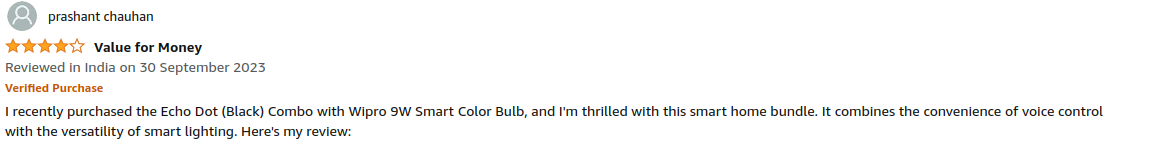

Vamos a extraer la información desde la siguiente página: https://www.amazon.in/Echo-Dot-3rd-Gen/product-reviews/B07PFFMP9P/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=1 

El siguiente script está dividido en los siguientes bloques:

- **BLOQUE A**: Introducción a Requests.
- **BLOQUE B**: Introducción a BeautifulSoup.
- **BLOQUE C**: Extracción de un elemento desde el documento HTML.
- **BLOQUE D**: Extracción automatizata de todas las reseñas y el numero de estrellas presentes en la página.
- **BLOQUE E**: Inferencia sobre el conjunto resultante.

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

import pickle
import joblib

from nltk.tokenize import word_tokenize
import re

### Bloque A: Introducción a Requests

El módulo *requests* es una biblioteca de Python que facilita el envío de solicitudes HTTP y el manejo de las respuestas. Se utiliza comúnmente para interactuar con servicios web, realizar solicitudes a APIs (interfaces de programación de aplicaciones), y recuperar información de páginas web.

In [ ]:
url = "https://www.amazon.in/Echo-Dot-3rd-Gen/product-reviews/B07PFFMP9P/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=1"

In [ ]:
# Enviar solicitud para recibir la información (contenido de la página web)
response = requests.???(url)

In [ ]:
# Status de la solicitud
response.???

Algunos de los posibles **status code**:
- 200: la solicitud ha tenido exito
- 404: el recurso solicitado no fue encontrado en el servidor
- 500: error en el servidor al procesar la solicitud
- 503: servidor temporalmente incapaz de manejar la solicitud. 

In [ ]:
# Contenido de la respuesta
print(response.???)

In [ ]:
# ¿De qué tipo es el contenido de la respuesta?
???(response.text)

### Bloque B: introducción a BeautifulSoup

Beautiful Soup es una biblioteca de Python que facilita la extracción de información de documentos HTML y XML. Es comúnmente utilizada para realizar tareas de web scraping, donde se desea extraer datos específicos de una página web.

Beautiful Soup transforma un documento HTML/XML en un árbol de objetos Python que se puede explorar y manipular de manera sencilla.

En este caso el documento que vamos a considerar es en formado HTML.

Ejemplo simple de documento HTML:
``````
<!DOCTYPE html>
<html>
<head>
    <title>Ejemplo HTML</title>
</head>
<body>
    <h1>Hola, mundo!</h1>
    <p>Este es un ejemplo de código HTML.</p>
    <ul>
        <li>Elemento de lista 1</li>
        <li>Elemento de lista 2</li>
        <li>Elemento de lista 3</li>
    </ul>
</body>
</html>
``````

In [ ]:
# Convertimos en un objeto BeautifulSoup el contenido de la respuesta (HTML)
soup = ???(response.text, '???.parser')
print(soup)

In [ ]:
# Comprobamos la conversión a objeto BeautifulSoup
type(soup)

### Bloque C: Extracción de un elemento

#### Encabezado

In [ ]:
# Encontrar el primer elemento con el tag 'head'
header = soup.find(???)
header

In [ ]:
# Extraer todo el texto del primer elemento con el tag 'head'
texto = header.???
texto

In [ ]:
# Eliminar caracteres en blanco al principio y al final del texto
texto.???()

#### Texto de una reseña

In [ ]:
# Búsqueda por tag y id de una reseña
review_section = soup.find('???', ???="???")
print(review_section)

In [ ]:
# El texto de la reseña esta contenido dentro un tag <span>. ¿Se podría hacer la busqueda por tag?
review_section.???("span")

In [ ]:
# Busqueda de todo los elementos "span" dentro de review_section
span_tags = review_section.???("span")
span_tags

In [ ]:
# Extraer el texto de la reseña desde la lista de los elementos con tag 'span'
span_tags[???].text

In [ ]:
# Busqueda de la reseña por tag + otro elemento
review= review_section.find("span", {'???': '???'})
review

In [ ]:
# Extración el texto
???

### Bloque D: Extracción automatizata de todas las reseñas y el numero de estrellas presentes en la página

In [ ]:
# Definición de la función para extraer todas las reseñas y los votos de un producto en una página

def reviews_scraper(url:str)-> pd.DataFrame:

    # creacíon del dataset donde se iran guaradando las informaciones
    df = pd.DataFrame(columns=['text','stars'])

    # request + parser
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')

    if r.status_code == 200: # OK

        # Busqueda de todas las sectiones que continen una reseña
        review_sections = soup.find_all('div', {'data-hook': 'review'}) # en este caso no sería efficiente buscar po id

        for item in review_sections:
            # Extracción del texto
            review = item.find('span', {'data-hook': 'review-body'}).text.strip()
            rating = item.find('a', {'data-hook': 'review-title'} ).find(???, {???: ???}).text.strip()

            # Nueva fila a agregar
            new_row = {'text': review, 'stars': rating}
            df = df.append(new_row, ignore_index=True)
    
        return df
    
    else:
        raise TypeError(f'Error en scraper la página, error:{r.status_code}')


In [ ]:
url = "https://www.amazon.in/Echo-Dot-3rd-Gen/product-reviews/B07PFFMP9P/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=1"

df = reviews_scraper(url)
df

In [ ]:
# Limpieza de la variable stars
df['stars'] = df['stars'].apply(lambda x: ???])
df

In [ ]:
# Guardamos el conjunto resultante
df.to_csv('../data/scraped_reviews.csv', index=False)

### BLOQUE E: Inferencia sobre el conjunto resultante
En esta última fase, vamos a hacer inferencia sobre el nuevo conjunto de datos.

In [ ]:
# Función para preprocesar el texto en crudo
def preprocess(text):    

    # Definir patrones para reemplazar/eliminar.
    alphaPattern      = "[^a-zA-Z]"
    sequencePattern   = r"(.)\1\1\1*"
    seqReplacePattern = r"\1\1"    

    
    # Crear lista de stopwords
    en_stop = set(stopwords.words('english')) - {'not','no'}

    # Lower Casing
    text = text.lower()

    # Reemplazar non-alphabets.
    text = re.sub(alphaPattern, " ", text)

     # Reemplazar letras consecutivas.
    text = re.sub(sequencePattern, seqReplacePattern, text)
    
    # Tokenizar texto
    tokens = word_tokenize(text)

    # Eliminar stopwords
    tokens = [word for word in tokens if word not in en_stop]
    
    # Eliminar stringas con menos de dos elementos
    tokens = [word for word in tokens if len(word)>2]
    
        
    return tokens

In [ ]:
# Cargar el vectorizer
vectorizer = joblib.???('../models/tfidf_vectorizer.joblib')
vectorizer

In [ ]:
# Cargar el modelo 
with open('../models/gradient_boosting_model.pkl', 'rb') as file:
    model = pickle.load(file)

model

In [ ]:
# Preprocesamos el nuevo texto
test_texts =  df['text'].apply(preprocess)
test_texts_vec = vectorizer.transform([" ".join(tokens) for tokens in test_texts])

In [ ]:
# Inferencia de las nuevas reseñas
model.???(test_texts_vec)

Estas últimas reseñas eran todas positivas. En este último paso, crearemos unas reseñas negativas manualmente para probar como de bien funciona el modelo con este tipo de textos.

In [ ]:
# Reseñas negativa
neg_text = [ "Bad experience! The worst product.", "How can they sell this product?Too bad"]

# Procesiamento
preprocessed_text= [preprocess(el) for el in neg_text]
neg_text = vectorizer.transform([" ".join(tokens) for tokens in preprocessed_text])

In [ ]:
# Inferencia reseñas negativa
model.predict(???)